<a href="https://colab.research.google.com/github/vaglino/V-prop-SNN/blob/main/V_prop_SNN__edge_based_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

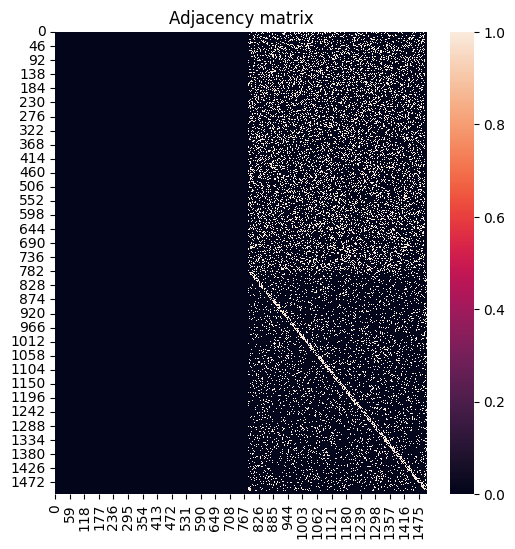

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Starting training…
Epoch 01 | train loss 0.5146 | val loss 0.2797 | val acc 92.59 %
Epoch 02 | train loss 0.2009 | val loss 0.2177 | val acc 94.27 %
Epoch 03 | train loss 0.1388 | val loss 0.1649 | val acc 95.67 %
Epoch 04 | train loss 0.0993 | val loss 0.1368 | val acc 96.33 %
Epoch 05 | train loss 0.0746 | val loss 0.1207 | val acc 96.52 %
Epoch 06 | train loss 0.0569 | val loss 0.1027 | val acc 97.10 %
Epoch 07 | train loss 0.0437 | val loss 0.0917 | val acc 97.18 %
Epoch 08 | train loss 0.0348 | val loss 0.0869 | val acc 97.68 %
Epoch 09 | train loss 0.0272 | val loss 0.0891 | val acc 97.56 %
Epoch 10 | train loss 0.0218 | val loss 0.0822 | val acc 97.68 %
Epoch 11 | train loss 0.0169 | val loss 0.0824 | val acc 97.96 %
Epoch 12 | train loss 0.0145 | val loss 0.0774 | val acc 97.96 %
Epoch 13 | train loss 0.0116 | val loss 0.0783 | val acc 98.08 %
Epoch 14 | train loss 0.0104 | val loss 0.0730 | val acc 98.19 %
Epoch 15 | train los

In [1]:
# -*- coding: utf-8 -*-

"""
Edge-list based Spiking Neural Network (SNN) for MNIST classification.
Implements an SNN using an edge-list representation for O(E) memory efficiency.
Trains on MNIST dataset and evaluates performance.
"""

# ——————————————————————————————————————————————————————————————
# Imports
# ——————————————————————————————————————————————————————————————

import jax, jax.numpy as jnp              # JAX for numerical computations and arrays
from jax import random, jit, lax         # JAX utilities: random numbers, JIT compilation, and scan
import numpy as np                       # NumPy for array operations
import matplotlib.pyplot as plt          # Matplotlib for plotting
from functools import partial            # Partial function application
import seaborn as sns                    # Seaborn for enhanced visualizations (e.g., heatmaps)
import optax                             # Optax for optimization
import time                              # Time module for measuring training duration
from sklearn.utils import resample       # Resampling utility for data subsampling
from sklearn.preprocessing import StandardScaler  # StandardScaler for data normalization
from skimage.transform import resize     # Image resizing utility
from keras.datasets import mnist         # MNIST dataset loader

# ——————————————————————————————————————————————————————————————
# Global Constants
# ——————————————————————————————————————————————————————————————

thresh = 0.5         # Threshold voltage for neuron firing
key = random.PRNGKey(1)  # Initial random key for JAX random operations
dt = ds = 1.0        # Time step (dt) and spatial step (ds), assumed equal
t_max = 30           # Maximum number of simulation time steps
tau = 10.0           # Membrane potential decay time constant
α = 0.5              # Unused parameter in this implementation
v_rest = 0.0         # Resting membrane potential

# ==============================================================
# 0. Helper Functions for Network Creation and Data Loading
# ==============================================================

def create_directed_small_world(
    n_total=402,     # Total number of neurons
    n_inputs=196,    # Number of input neurons
    n_outputs=10,    # Number of output neurons
    k_nearest=4,     # Number of nearest neighbors in ring topology
    p_rewire=0.1,    # Probability of rewiring in Watts-Strogatz model
    p_connect=0.1    # Probability of additional random connections
):
    """
    Creates a directed small-world adjacency matrix:
    - No inbound edges to inputs
    - No outbound edges from outputs
    - Hidden layer with ring topology and rewiring
    A[i,j] == 1 indicates an edge from neuron i to j
    """
    key = random.PRNGKey(0)  # Fixed random key for reproducibility

    # Initialize adjacency matrix with zeros
    A = jnp.zeros((n_total, n_total), dtype=jnp.int32)

    # Define hidden layer indices
    hidden_start = n_inputs          # Start index of hidden layer
    hidden_end = n_total - n_outputs  # End index of hidden layer
    n_hidden = hidden_end - hidden_start  # Number of hidden neurons
    hidden_slice = slice(hidden_start, hidden_end)  # Slice for hidden layer

    # Create regular ring lattice for hidden layer
    indices = jnp.arange(hidden_start, hidden_end)  # Indices of hidden neurons
    for i in range(n_hidden):
        # Connect each hidden neuron to k_nearest neighbors in a ring
        ring_targets = (i + jnp.arange(1, k_nearest + 1)) % n_hidden + hidden_start
        A = A.at[indices[i], ring_targets].set(1)  # Set edges in adjacency matrix

    # Apply Watts-Strogatz rewiring to hidden layer
    hidden_connections = A[hidden_slice, hidden_slice]  # Extract hidden layer submatrix
    key, subkey = random.split(key)  # Split key for random operations
    rand_mat = random.uniform(subkey, hidden_connections.shape)  # Random matrix for rewiring
    to_rewire = (rand_mat < p_rewire) & (hidden_connections == 1)  # Edges to rewire
    hidden_connections = hidden_connections & (~to_rewire)  # Remove rewired edges
    src_rows, _ = jnp.where(to_rewire)  # Source indices of edges to rewire
    num_r = src_rows.shape[0]  # Number of edges to rewire
    if num_r:
        key, subkey = random.split(key)  # Split key again
        new_cols = random.randint(subkey, (num_r,), 0, n_hidden)  # Random new targets
        for s, t in zip(src_rows, new_cols):
            if s != t:  # Avoid self-loops
                hidden_connections = hidden_connections.at[s, t].set(1)  # Rewire edge
    A = A.at[hidden_slice, hidden_slice].set(hidden_connections)  # Update adjacency matrix

    # Add extra random shortcuts in hidden layer
    key, subkey = random.split(key)
    extra = (random.uniform(subkey, (n_hidden, n_hidden)) < p_connect)  # Random connections
    extra = extra & (~(hidden_connections.T == 1))  # Avoid reciprocal connections
    hidden_connections = (hidden_connections == 1) | extra  # Add new connections
    A = A.at[hidden_slice, hidden_slice].set(hidden_connections.astype(jnp.int32))

    # Connect inputs to hidden layer
    key, subkey = random.split(key)
    in2hid = (random.uniform(subkey, (n_inputs, n_hidden)) < 2*p_connect)  # Double probability
    A = A.at[:n_inputs, hidden_slice].set(in2hid)  # Set input-to-hidden edges

    # Connect hidden layer to outputs
    key, subkey = random.split(key)
    hid2out = (random.uniform(subkey, (n_hidden, n_outputs)) < 2*p_connect)
    A = A.at[hidden_slice, n_total-n_outputs:].set(hid2out)  # Set hidden-to-output edges

    # Ensure each input has at least one outgoing edge
    need = (jnp.sum(A[:n_inputs], axis=1) == 0)  # Inputs with no outgoing edges
    if jnp.any(need):
        key, subkey = random.split(key)
        t = random.randint(subkey, (n_inputs,), hidden_start, hidden_end)  # Random targets
        for i in range(n_inputs):
            if need[i]:
                A = A.at[i, t[i]].set(1)  # Add an outgoing edge

    # Ensure each output has at least one incoming edge
    need = (jnp.sum(A[:, n_total-n_outputs:], axis=0) == 0)  # Outputs with no incoming edges
    if jnp.any(need):
        key, subkey = random.split(key)
        s = random.randint(subkey, (n_outputs,), hidden_start, hidden_end)  # Random sources
        for i in range(n_outputs):
            if need[i]:
                A = A.at[s[i], n_total-n_outputs+i].set(1)  # Add an incoming edge

    # Remove forbidden connections
    A = A.at[:, :n_inputs].set(0)      # No inbound edges to inputs
    A = A.at[-n_outputs:, :].set(0)    # No outbound edges from outputs

    # Define layer information for reference
    layers = [
        ('Input', (n_inputs,), 0, n_inputs-1),
        ('Hidden', (n_hidden,), hidden_start, hidden_end-1),
        ('Output', (n_outputs,), n_total-n_outputs, n_total-1)
    ]
    return A, layers

def plot_adjacency_matrix(A):
    """Plots the adjacency matrix as a heatmap."""
    plt.figure(figsize=(6, 6))  # Set figure size
    sns.heatmap(A)              # Create heatmap using Seaborn
    plt.title("Adjacency matrix")  # Add title
    plt.show()                  # Display the plot

def load_mnist_data(
    train_size=0.8, val_size=0.1, test_size=0.1,  # Proportions for data split
    resample_fraction=0.2, target_size=(14,14),    # Resampling fraction and image size
    random_state=42                                # Seed for reproducibility
):
    """
    Loads, normalizes, resizes, and splits MNIST dataset into train/val/test sets.
    Returns JAX arrays for inputs and one-hot encoded labels.
    """
    if not np.isclose(train_size + val_size + test_size, 1.0):
        raise ValueError("Splits must sum to 1.0")  # Validate split proportions

    # Load and concatenate MNIST train and test sets
    (X_tr, y_tr), (X_te, y_te) = mnist.load_data()
    X, y = np.concatenate([X_tr, X_te]), np.concatenate([y_tr, y_te])

    # Normalize pixel values to [0,1]
    X = X.astype(np.float32) / 255.0

    # Standardize data (zero mean, unit variance)
    X = StandardScaler().fit_transform(X.reshape(len(X), -1)).reshape(X.shape)

    # Resize images to target size
    def _resize(imgs, size):
        out = np.zeros((len(imgs), *size))  # Initialize output array
        for i in range(len(imgs)):
            out[i] = resize(imgs[i], size, anti_aliasing=True)  # Resize each image
        return out
    X = _resize(X, target_size)[..., None]  # Add channel dimension

    # Subsample the dataset
    n_tot = int(resample_fraction * len(X))  # Number of samples to keep
    X_small, y_small = resample(X, y, n_samples=n_tot, random_state=random_state)

    # Split into train, validation, and test sets
    n_tr = int(n_tot * train_size)    # Training set size
    n_v = int(n_tot * val_size)        # Validation set size
    perm = np.random.RandomState(random_state).permutation(n_tot)  # Random permutation
    tr, v, te = perm[:n_tr], perm[n_tr:n_tr+n_v], perm[n_tr+n_v:]  # Indices for splits

    # Convert to JAX arrays and one-hot encode labels
    x_train, x_val, x_test = map(jnp.array, (X_small[tr], X_small[v], X_small[te]))
    y_train = jax.nn.one_hot(y_small[tr], 10)  # One-hot encode training labels
    y_val = jax.nn.one_hot(y_small[v], 10)     # One-hot encode validation labels
    y_test = jax.nn.one_hot(y_small[te], 10)   # One-hot encode test labels

    return (x_train, x_val, x_test,
            y_train, y_val, y_test,
            y_small[tr], y_small[v], y_small[te])  # Return data and labels

# Basic mathematical helper functions
@jit
def v(ds, dt): return ds / dt  # Compute velocity as distance per time

@jit
def relu_shift(x, th): return jnp.maximum(0., x - th)  # Shifted ReLU activation

# ==============================================================
# 1. Build the Graph and Convert to Edge Lists
# ==============================================================

# Create adjacency matrix with specified topology
adj_dense, layers = create_directed_small_world(
    n_total=1510,    # Total neurons: 784 inputs + hidden + 10 outputs
    n_inputs=784,    # Matches 28x28 MNIST images
    n_outputs=10,    # One output per digit
    k_nearest=16,    # Ring connectivity in hidden layer
    p_rewire=0.4,    # Rewiring probability for small-world properties
    p_connect=0.1    # Additional connection probability
)
plot_adjacency_matrix(adj_dense)  # Visualize the adjacency matrix

# Define global network parameters
N_NEURONS = adj_dense.shape[0]  # Total number of neurons
N_INPUTS = 784                  # Number of input neurons
N_OUTPUTS = 10                  # Number of output neurons

# Convert adjacency matrix to edge lists
src_np, tgt_np = np.nonzero(np.array(adj_dense))  # Get source and target indices
src = jnp.array(src_np, dtype=jnp.int32)  # Source neuron indices for edges
tgt = jnp.array(tgt_np, dtype=jnp.int32)  # Target neuron indices for edges
E = len(src)  # Total number of edges

vmax = v(ds, dt)  # Maximum spike velocity

# ==============================================================
# 2. Per-Edge Initialization
# ==============================================================

def initialize_lengths(adj, lengths=jnp.arange(4., 6., 1.), key=random.PRNGKey(1)):
    """Initialize edge lengths randomly from a given array."""
    key, sub = random.split(key)  # Split random key
    L = adj * random.choice(sub, lengths, adj.shape)  # Assign random lengths where edges exist
    return L, key

def initialize_weights(adj, p_inhib=0.0, key=random.PRNGKey(2)):
    """Initialize edge weights with uniform distribution and optional inhibition."""
    key, sk1, sk2 = random.split(key, 3)  # Split key for multiple uses
    W = adj * random.uniform(sk1, adj.shape)  # Uniform weights [0,1] where edges exist
    sign = (random.uniform(sk2, adj.shape) > p_inhib) * 2 - 1  # Signs based on inhibition prob
    W = W * sign * adj  # Apply signs to weights
    return W, key

def initialise_edges(adj, key):
    """
    Initialize edge lengths and weights for edge-list representation.
    Forces input edges to have length 3.0.
    """
    Lmat, key = initialize_lengths(adj, jnp.arange(3., 8., ds), key)  # Random lengths [3,8)
    L_e = Lmat[src, tgt]  # Extract edge lengths for edge list
    L_e = L_e.at[src < N_INPUTS].set(3.0)  # Set fixed length for input edges
    Wmat, key = initialize_weights(adj, 0.0, key)  # Initialize weights (no inhibition)
    W_e = Wmat[src, tgt]  # Extract edge weights for edge list
    return L_e, W_e, key

# Initialize edge properties
L_e, W_e, key = initialise_edges(adj_dense, key)

# ==============================================================
# 3. Edge-Tensor Primitives
# ==============================================================

SRC_EDGES = (src < N_INPUTS)  # Boolean mask for edges originating from inputs

def scatter_edges_to_nodes(edge_vals):
    """Aggregate edge values to target neurons: (B,E) -> (B,N)."""
    return jax.vmap(lambda ev: jnp.zeros(N_NEURONS).at[tgt].add(ev))(edge_vals)

@jit
def take_step_edges(S): return S + (S > 0) * dt * vmax  # Advance active spikes by one step

@jit
def check_arrival_edges(S, L_e, *, atol=1e-5, rtol=1e-8):
    """Check if spikes have reached their targets with tolerance."""
    return jnp.isclose(S, L_e, atol=atol, rtol=rtol)  # Compare positions to lengths

@jit
def excite_inputs_edges(S, V, x_batch):
    """Excite input neurons by setting spike positions and voltages."""
    B = x_batch.shape[0]  # Batch size
    pix = x_batch.reshape(B, -1)  # Flatten images to (B, 784)
    idle_mask = (S[:, SRC_EDGES] == 0)  # Identify idle input edges
    # Start idle input edges moving
    S = S.at[:, SRC_EDGES].set(jnp.where(idle_mask, dt*vmax, S[:, SRC_EDGES]))
    # Set voltages to pixel values for idle edges
    V = V.at[:, SRC_EDGES].set(jnp.where(idle_mask, pix[:, src[SRC_EDGES]], V[:, SRC_EDGES]))
    return S, V

@jit
def synapse_integration_edges(Vm, W_e, V_arr):
    """Integrate synaptic inputs and update membrane potentials."""
    I_syn = scatter_edges_to_nodes(V_arr * W_e)  # Compute synaptic current
    dV = (-Vm + I_syn) * (dt / tau)  # Membrane potential change
    Vm = Vm + dV  # Update membrane potential
    Y = jnp.maximum(0., Vm - thresh)  # Output after threshold
    return Y, Vm

@jit
def update_spikes_edges(S, V_exc, fired):
    """Spawn new spikes from fired neurons on idle edges."""
    idle = (S == 0)  # Identify idle edges
    newS = fired[:, src] & idle  # New spikes where source neurons fired
    newV = newS * V_exc[:, src]  # Voltages for new spikes
    return newS, newV

@jit
def delete_finished_edges(S, V, arrived):
    """Remove spikes that have arrived at their targets."""
    return S * (~arrived), V * (~arrived)  # Zero out finished edges

@jit
def reset_vm(Vm, fired):
    """Reset membrane potential of fired neurons."""
    return Vm - Vm*fired - 0.2*fired  # Reset and subtract additional 0.2

# ==============================================================
# 4. RSNN Simulation Step and Inference
# ==============================================================

def make_edge_step(W_e, L_e, dropout_rate):
    @jit
    def _step(carry, key):
        S, V, Vm, x, acc = carry  # Unpack carry: spikes, voltages, potentials, inputs, accumulator

        # 1. Excite input neurons with current batch
        S, V = excite_inputs_edges(S, V, x)

        # 2. Check for spike arrivals
        arrived = check_arrival_edges(S, L_e)  # Identify arrived spikes
        V_arr = V * arrived  # Voltages of arrived spikes

        # 3. Integrate synaptic inputs
        V_exc, Vm = synapse_integration_edges(Vm, W_e, V_arr)

        # 4. Determine firing neurons (exclude outputs)
        fired = V_exc > 0  # Neurons above threshold
        fired = fired.at[:, -N_OUTPUTS:].set(False)  # Output neurons don’t fire

        # 5. Apply dropout to firing neurons
        keep_p = 1.0 - dropout_rate  # Probability of keeping a neuron
        mask = random.bernoulli(key, keep_p, fired.shape)  # Dropout mask
        fired &= mask  # Apply dropout
        V_exc = V_exc * mask / keep_p  # Scale voltages to maintain expected value

        # 6. Spawn new spikes
        newS, newV = update_spikes_edges(S, V_exc, fired)

        # 7. Delete arrived spikes
        S, V = delete_finished_edges(S, V, arrived)

        # 8. Accumulate membrane potential before reset
        acc = acc + Vm  # Add current Vm to running sum

        # 9. Reset fired neurons
        Vm = reset_vm(Vm, fired)

        # 10. Advance spikes and add new ones
        S = take_step_edges(S) + newS * dt * vmax  # Move existing and start new spikes
        V = V + newV  # Update voltages with new spikes

        return (S, V, Vm, x, acc), None  # Return updated state
    return _step

@jit
def RSNN_inference_edge(W_e, L_e, x_batch, rng_key, dropout_rate):
    """Run SNN simulation over t_max steps and return average membrane potential."""
    B = x_batch.shape[0]  # Batch size
    S = V = jnp.zeros((B, E))  # Initialize spike positions and voltages
    Vm = jnp.zeros((B, N_NEURONS))  # Initialize membrane potentials
    acc = jnp.zeros((B, N_NEURONS))  # Accumulator for averaging Vm

    # Split random key for each time step
    keys = random.split(rng_key, t_max)

    # Run simulation over time steps
    (S, V, Vm, x, acc), _ = lax.scan(
        make_edge_step(W_e, L_e, dropout_rate),
        (S, V, Vm, x_batch, acc),
        keys
    )
    return acc / t_max  # Return average membrane potential

# ==============================================================
# 5. Loss and Prediction Functions
# ==============================================================

@jit
def loss_edge(W_e, L_e, xb, yb, key, drop):
    """Compute cross-entropy loss from output neurons' average membrane potential."""
    Vm_mean = RSNN_inference_edge(W_e, L_e, xb, key, drop)  # Get average Vm
    logits = Vm_mean[:, -N_OUTPUTS:]  # Extract output neuron potentials (B, 10)
    probs = jax.nn.softmax(logits, axis=1)  # Convert to probabilities
    return -jnp.mean(jnp.sum(yb * jnp.log(probs + 1e-8), axis=1))  # Cross-entropy loss

@jit
def predict_edge(W_e, L_e, xb):
    """Predict class labels using argmax of output neurons' average Vm."""
    Vm_mean = RSNN_inference_edge(W_e, L_e, xb, key, 0.0)  # No dropout during prediction
    logits = Vm_mean[:, -N_OUTPUTS:]  # Output neuron potentials
    return jnp.argmax(logits, axis=1)  # Return class with highest potential

# ==============================================================
# 6. Optimizer Setup
# ==============================================================

# Define optimizer with gradient clipping and Adam
optimizer = optax.chain(
    optax.clip_by_global_norm(5.0),  # Clip gradients to max norm 5.0
    optax.adam(0.005)                # Adam optimizer with learning rate 0.005
)

opt_state = optimizer.init(W_e)  # Initialize optimizer state with edge weights

@jit
def train_edge_step(W_e, L_e, opt_state, xb, yb, key):
    """Perform one training step: compute loss, gradients, and update weights."""
    loss, grads = jax.value_and_grad(loss_edge)(W_e, L_e, xb, yb, key, 0.2)  # Loss and grads
    updates, opt_state = optimizer.update(grads, opt_state, W_e)  # Compute updates
    W_e = optax.apply_updates(W_e, updates)  # Apply updates to weights
    return W_e, opt_state, loss

# ==============================================================
# 7. Data Loading
# ==============================================================

# Load and preprocess MNIST data
(x_train, x_val, x_test,
 y_train, y_val, y_test,
 y_train_lbl, y_val_lbl, y_test_lbl) = load_mnist_data(
    train_size=0.8, val_size=0.1, test_size=0.1,  # Split proportions
    resample_fraction=1.0, target_size=(28,28),    # Use full dataset, 28x28 images
    random_state=42                                # Fixed seed
)

# ==============================================================
# 8. Training Loop
# ==============================================================

batch_size = 32    # Number of samples per batch
epochs = 20        # Number of training epochs
rng = random.PRNGKey(42)  # Random key for training

print("Starting training…")
t0 = time.time()  # Record start time
for ep in range(epochs):
    # Shuffle training data
    perm = np.random.permutation(len(x_train))  # Random permutation of indices
    x_tr, y_tr = x_train[perm], y_train[perm]   # Apply permutation to data

    # Train on batches
    train_loss, nb = 0.0, 0  # Initialize loss accumulator and batch counter
    rng, sk = random.split(rng)  # Split random key
    for i in range(0, len(x_train) - batch_size + 1, batch_size):
        xb, yb = x_tr[i:i+batch_size], y_tr[i:i+batch_size]  # Extract batch
        sk, sub = random.split(sk)  # Split key for this batch
        W_e, opt_state, lv = train_edge_step(W_e, L_e, opt_state, xb, yb, sub)  # Train step
        train_loss += float(lv)  # Accumulate loss
        nb += 1  # Increment batch counter
    train_loss /= nb  # Average training loss

    # Evaluate on validation set (no dropout)
    val_loss, nbv = 0.0, 0  # Initialize validation loss and batch counter
    preds = []  # List to store predictions
    for j in range(0, len(x_val) - batch_size + 1, batch_size):
        xb, yb = x_val[j:j+batch_size], y_val[j:j+batch_size]  # Extract validation batch
        rng, sub = random.split(rng)  # Split key
        val_loss += float(loss_edge(W_e, L_e, xb, yb, sub, 0.0))  # Compute loss
        nbv += 1  # Increment batch counter
        preds.append(predict_edge(W_e, L_e, xb))  # Store predictions
    val_loss /= nbv  # Average validation loss
    preds = jnp.concatenate(preds)  # Concatenate predictions
    val_acc = float((preds == y_val_lbl[:len(preds)]).mean()) * 100.0  # Compute accuracy

    # Print epoch summary
    print(f"Epoch {ep+1:02d} | train loss {train_loss:.4f} | val loss {val_loss:.4f} | val acc {val_acc:.2f} %")

print("Training finished in", round(time.time() - t0, 1), "s")

# ==============================================================
# 9. Test Accuracy
# ==============================================================

pred = []  # List to store test predictions
for i in range(0, len(x_test) - batch_size + 1, batch_size):
    pred.append(predict_edge(W_e, L_e, x_test[i:i+batch_size]))  # Predict on test batches
pred = jnp.concatenate(pred)  # Concatenate predictions
acc = (pred == y_test_lbl[:len(pred)]).mean() * 100  # Compute test accuracy
print(f"Final test accuracy: {acc:.2f} %")

if __name__ == "__main__":
    print("Edge-list SNN – bug-fixed and self-contained")